In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import pickle
%matplotlib widget

PROJECT_ROOT = os.path.abspath(os.path.join(os.path.abspath('../..'),os.pardir))
sys.path.append(PROJECT_ROOT)

from electronTransportCode.SimulationDomain import SimulationDomain
from electronTransportCode.Material import unitDensityMaterial
from electronTransportCode.SimOptions import KDTestSource
from electronTransportCode.ParticleModel import DiffusionTestParticlev2
from electronTransportCode.MCParticleTracer import AnalogParticleTracer, KDParticleTracer
from electronTransportCode.MCEstimator import TrackEndEstimator


In [2]:
# Load all simulation results from data/
timingsK, timingsKD, scatteringRateList, dS, collisionsK, collisionsKD = pickle.load(open('data/timings.pkl', 'rb'))
print(timingsK)
print(timingsKD)

[[  0.90933748   0.91286106]
 [  0.96914268   0.97378159]
 [  1.11739937   1.11895758]
 [  1.52782978   1.52571875]
 [  2.66976611   2.6700751 ]
 [  5.87355144   5.86682806]
 [ 14.62112246  14.645199  ]
 [ 39.12501183  38.99347429]
 [106.64897726 106.49220504]
 [295.20626135 299.64796597]]
[[0.95244693 0.9530737 ]
 [1.0506828  1.04846321]
 [1.26108401 1.26289571]
 [1.64974695 1.63843405]
 [1.98967593 1.98454353]
 [2.05313157 2.05424287]
 [2.0492152  2.0870321 ]
 [2.03801085 2.03997287]
 [2.02944106 2.05547265]
 [2.07721234 2.06532155]]


In [3]:
# Experimental speed-up
speedUp = timingsK/timingsKD
avgSpeedUp = speedUp.mean(axis=1)
varSpeedUp = speedUp.var(axis=1)

# Theoretical speed-up
Kexp = scatteringRateList*dS
KDexp = 1.0-np.exp(-scatteringRateList*dS)
theoreticalSpeedUp = Kexp/KDexp

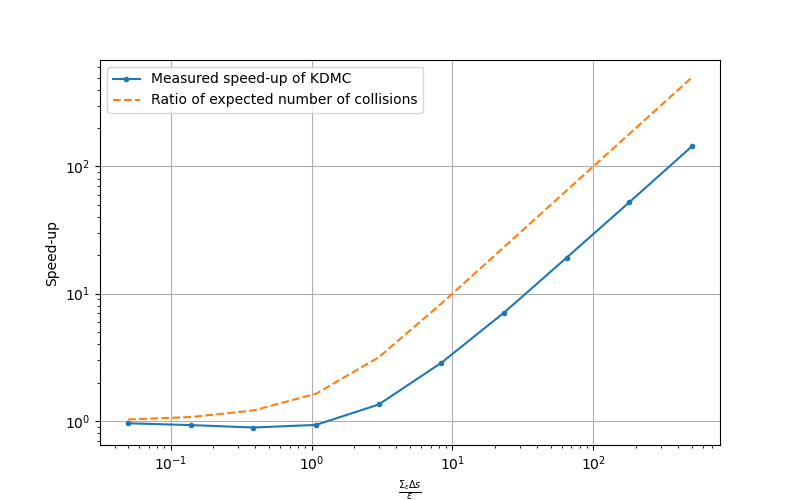

In [4]:
# Plotting
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5.0))

ax1.loglog(scatteringRateList*dS, avgSpeedUp, '.-', label='Measured speed-up of KDMC')
ax1.loglog(scatteringRateList*dS, theoreticalSpeedUp, '--', label='Ratio of expected number of collisions')
ax1.set_xlabel('$ \\frac{ \Sigma_{\epsilon} \Delta s}{\epsilon}$')
ax1.set_ylabel('Speed-up')
ax1.legend()
ax1.grid()

In [5]:
varSpeedUp

array([2.35499865e-06, 1.01671632e-05, 3.47311293e-10, 6.51781261e-06,
       3.28672168e-06, 5.80938860e-06, 3.46622179e-03, 1.71993068e-03,
       1.37567962e-01, 2.20348461e+00])

In [6]:
print(collisionsK)
print(collisionsKD)
print(scatteringRateList*dS)
# The 0.04% is the probability a particle collides within distance 5 of the source with rate 1/100. 

[  1.04448   1.13736   1.37848   2.08088   4.00016   9.35752  24.15928
  65.54328 180.68056 500.94888]
[[1.      0.0436 ]
 [1.      0.12632]
 [1.      0.31304]
 [1.      0.65944]
 [1.      0.94736]
 [1.      0.99976]
 [1.      1.     ]
 [1.      1.     ]
 [1.      1.     ]
 [1.      1.     ]]
[5.00000000e-02 1.39127970e-01 3.87131841e-01 1.07721735e+00
 2.99742125e+00 8.34050269e+00 2.32079442e+01 6.45774833e+01
 1.79690683e+02 5.00000000e+02]


In [7]:
NB_PARTICLES = 10
xmax = 25
ymin = -xmax; ymax = xmax; ybins = 1  # No internal grid cell crossings
zmin = -xmax; zmax = xmax; zbins = 1
simDomain = SimulationDomain(ymin, ymax, zmin, zmax, ybins, zbins, material=unitDensityMaterial)
eSource = 5.0
pointSourceSim = KDTestSource(minEnergy=0.0, rngSeed=4, eSource=eSource)
particle = DiffusionTestParticlev2(Es=0.07, sp=1.0)
warmUpEstimator1 = TrackEndEstimator(simDomain, nb_particles=NB_PARTICLES, setting='x')
warmUpEstimator2 = TrackEndEstimator(simDomain, nb_particles=NB_PARTICLES, setting='x')

particleTracerKD = KDParticleTracer(particle=particle, simOptions=pointSourceSim, simDomain=simDomain, dS = eSource)  # stepsize is final time!
particleTracerK = AnalogParticleTracer(particle=particle, simOptions=pointSourceSim, simDomain=simDomain)  # stepsize is final time!